# Assignment 1

### genrate maze
Maze is genrated by randomly placing obstacle and walls in `NxN` matrix.
some walls and obstacles and walls can fixed by passing parameters `fixed_obstacles` and `fixed_walls`.

In [2]:
import random

def generate_maze(size, fixed_obstacles=None, fixed_walls=None):
    if size < 5:
        raise ValueError("Grid size must be at least 5x5.")
    
    grid = [[' ' for _ in range(size)] for _ in range(size)]
    
    # Place fixed obstacles from input i220512
    if fixed_obstacles:
        for (x, y) in fixed_obstacles:
            if 0 <= x < size and 0 <= y < size:
                grid[x][y] = 'O'
    
    # Place fixed walls from input
    if fixed_walls:
        for (x, y) in fixed_walls:
            if 0 <= x < size and 0 <= y < size:
                grid[x][y] = '-'
    
    num_obstacles = size
    for _ in range(num_obstacles):
        x = random.randint(1, size - 2)
        y = random.randint(1, size - 2)
        if grid[x][y] == ' ':
            grid[x][y] = 'O'
    
    for _ in range(size * 2):
        x = random.randint(0, size - 1)
        y = random.randint(0, size - 1)
        if grid[x][y] == ' ':
            grid[x][y] = '-'
    
    grid[0][0] = 'A'
    grid[size - 1][size - 1] = 'G'
    
    return grid

### Printing Functions
- `print_grid(grid)` prints the maze genrated it take maze or grid as input.
- `print_path(grid, path)` prints the path genrated through the maze search algorithms it print `*` on the path. this code can also be modified to show the direction of movment. 
- `print_visited_path(grid, path)` this function is same as print_path but this function is used to print all the points the algorthm has visited.

In [3]:
def print_grid(grid):
    size = len(grid)
    print('# ' * (size + 2))
    for row in grid:
        print('#', ' '.join(row), '#')
    print('# ' * (size + 2))

def print_path(grid, path):
    grid_copy = [row[:] for row in grid]
    
    # Mark the path on the grid with directions for now it is '*' 
    for i in range(1, len(path)):
        prev_pos = path[i - 1]
        curr_pos = path[i]
        if grid_copy[curr_pos[0]][curr_pos[1]] not in ('A', 'G'):
            if curr_pos[0] == prev_pos[0] - 1:
                grid_copy[curr_pos[0]][curr_pos[1]] = '*'  # Up ^
            elif curr_pos[0] == prev_pos[0] + 1:
                grid_copy[curr_pos[0]][curr_pos[1]] = '*'  # Down v
            elif curr_pos[1] == prev_pos[1] - 1:
                grid_copy[curr_pos[0]][curr_pos[1]] = '*'  # Left <
            elif curr_pos[1] == prev_pos[1] + 1:
                grid_copy[curr_pos[0]][curr_pos[1]] = '*'  # Right >
    
    size = len(grid_copy)
    print('# ' * (size + 2))
    for row in grid_copy:
        print('#', ' '.join(row), '#')
    print('# ' * (size + 2))

def print_visited_path(grid, path):
    grid_copy = [row[:] for row in grid]
    for pos in path:
        if grid_copy[pos[0]][pos[1]] not in ('A', 'G'):
            grid_copy[pos[0]][pos[1]] = '*'
    
    print("Maze with Path:")
    print_grid(grid_copy)

### Agent
agent is the pointer or node that propogate throughout the maze.
- `get_neighbors(self, position, grid)` return all the valid paths the an agent can move.
- `heuristic(self, position, goal)` it return the heuristic cost upto the goal points. In our case it is Manhattan distance

In [4]:
class Agent:
    def __init__(self, position, energy, parent=None):
        self.position = position
        self.energy = energy
        self.parent = parent
        self.path = set()
    
    def get_neighbors(self, position, grid):
        neighbors = []
        x, y = position
        rows, cols = len(grid), len(grid[0])
        directions = [ (1, 0), (0, 1), (-1, 0), (0, -1), ]
        
        for direction in directions:
            new_x, new_y = x + direction[0], y + direction[1]
            if 0 <= new_x < rows and 0 <= new_y < cols and grid[new_x][new_y] != '-':
                neighbors.append((new_x, new_y))
        return neighbors
    def heuristic(self, position, goal):
        # Manhattan distance as the heuristic
        return abs(position[0] - goal[0]) + abs(position[1] - goal[1])

## IDDFS
This code snippet is implementing an Iterative Deepening Depth-First Search (`IDDFS`) algorithm.
Here's a breakdown of what the code is doing:
- It itrativlty increase the depth
- then apply dfs in each depth

In [5]:
def iddfs(start, goal, grid, agent):
    def dfs(agent_, depth, visited):
        if depth < 0:
            return None, 0
        if agent_.position == goal:
            return [agent_.position], 0 

        visited.add(agent_.position)
        for neighbor in agent.get_neighbors(agent_.position, grid):
            if neighbor not in visited:
                # Cost of moving to a cell is 2 if it contains an obstacle, 1 otherwise
                cost = 2 if grid[neighbor[0]][neighbor[1]] == 'O' else 1
                if agent_.energy >= cost:
                    child_agent = Agent(neighbor, agent_.energy - cost, agent_)
                    path, energy_used = dfs(child_agent, depth - cost, visited)
                    if path:
                        return [agent_.position] + path, energy_used + cost
        return None, 0
    
    max_depth = len(grid) * len(grid[0])
    all_visited = set()
    all_visited_count = 0

    for depth in range(max_depth):
        visited = set()
        result, energy_consumed = dfs(Agent(start, agent.energy), depth, visited)
        for pos in visited:
            all_visited.add(pos)
            all_visited_count += 1
        if result:
            return result, energy_consumed, all_visited,all_visited_count
    return None, 0, all_visited, all_visited_count


## UCS

**Uniform Cost Search (UCS)** finds the shortest path in a grid by always exploring the lowest-cost path first

- it begin at the starting position with a cost of `0`.
- Uses a queue to explore nodes with the lowest cost first.
- Check each node's neighbors:
   - Moving to an empty cell costs `1`.
   - Moving to an obstacle costs `2`.
- Update the cost if a cheaper path is found.
- When reaching the goal, reconstruct and return the path and total cost.

If the goal is reached, UCS returns the path, total cost, visited nodes, and their count. If not, it returns `None`.

In [6]:

import heapq

def ucs(start, goal, grid, agent):
    # Priority queue to store nodes to explore
    frontier = []
    heapq.heappush(frontier, (0, start))  # (cost, position)

    all_visited = set()
    all_visited_count = 0
    
    # Dictionary to store the least cost to reach each node
    cost_so_far = {start: 0}
    came_from = {start: None}

    while frontier:
        current_cost, current = heapq.heappop(frontier)
        all_visited.add(current)
        all_visited_count += 1

        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path, current_cost, all_visited, all_visited_count

        for neighbor in agent.get_neighbors(current, grid):
            # Calculate the cost to reach the neighbor
            cost = 2 if grid[neighbor[0]][neighbor[1]] == 'O' else 1
            new_cost = current_cost + cost
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost
                heapq.heappush(frontier, (priority, neighbor))
                came_from[neighbor] = current
    
    return None, 0, all_visited, all_visited_count

## A*
- It checks both the heuristic and the actual cost of the path 
- Then it calculates the value of f(n) which is equal to h(n) and g(n)
- The heuristic is calculated using the manhattan distance or the euclidean distance

In [7]:
def astar(start, goal, grid, agent):
    frontier = []
    heapq.heappush(frontier, (0, start))  # (f(n), position)
    
    cost_so_far = {start: 0}  # g(n)
    came_from = {start: None}

    all_visited = set()
    all_visited_count = 0

    while frontier:
        current_f, current = heapq.heappop(frontier)
        all_visited.add(current)
        all_visited_count += 1

        if current == goal:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path, cost_so_far[goal], all_visited, all_visited_count

        for neighbor in agent.get_neighbors(current, grid):
            # for 'O' cost is 2, otherwise 1
            cost = 2 if grid[neighbor[0]][neighbor[1]] == 'O' else 1
            new_cost = cost_so_far[current] + cost  # g(n) + c(n, n')
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + agent.heuristic(neighbor, goal)  # f(n) = g(n) + h(n)
                heapq.heappush(frontier, (priority, neighbor))
                came_from[neighbor] = current
    
    return None, 0, all_visited, all_visited_count

In [8]:
# Set grid size and generate maze
size = 12
fixed_obstacles = [(1, 1), (6, 2), (3, 3), (4, 4)]
fixed_walls = [(2, 4), (5, 5), (8, 8)]
grid = generate_maze(size, fixed_obstacles, fixed_walls)

# Print generated maze
print("Generated Maze:")
print_grid(grid)

# Start and goal positions
start = (0, 0)
goal = (size - 1, size - 1)

# Create agent with initial energy
initial_energy = size * size
agent = Agent(start, initial_energy)

Generated Maze:
# # # # # # # # # # # # # # 
# A                       #
#   O   - O     -       - #
#     O - -       -   -   #
#       O   O -           #
#     -   O   O       -   #
#       -   -             #
#     O   -         - O   #
#         O         O O   #
# -       -     - -   O - #
#             - -         #
#             O   - - O   #
# -                     G #
# # # # # # # # # # # # # # 


In [9]:
# Create agent with initial energy
initial_energy = size * size
agent = Agent(start, initial_energy)

# Run IDDFS
path,energy_consumed,idfs_visited,idfs_visited_count = iddfs(start, goal, grid, agent)
if path:
    print("Energy consumed by IDDFS:", energy_consumed)
    print("Total visited by IDDFS:", len(idfs_visited))
    print("Total visited by IDDFS:", idfs_visited_count)
    print_path(grid, path)
else:
    print("No path found.")

Energy consumed by IDDFS: 22
Total visited by IDDFS: 108
Total visited by IDDFS: 970
# # # # # # # # # # # # # # 
# A                       #
# * O   - O     -       - #
# *   O - -       -   -   #
# *     O   O -           #
# *   -   O   O       -   #
# *     -   -             #
# *   O   -         - O   #
# * *     O         O O   #
# - *     -     - -   O - #
#   *         - -         #
#   *         O   - - O   #
# - * * * * * * * * * * G #
# # # # # # # # # # # # # # 


In [10]:
# Create agent with initial energy
initial_energy = size * size
agent = Agent(start, initial_energy)

# Run UCS
path, energy_consumed, ucs_visited, ucs_visited_count = ucs(start, goal, grid, agent)
if path:
    print("Energy consumed by UCS:", energy_consumed)
    print("Total visited by UCS:", len(ucs_visited))
    print("Total visited by UCS:", ucs_visited_count)
    print_path(grid, path)
else:
    print("No path found.")

Energy consumed by UCS: 22
Total visited by UCS: 120
Total visited by UCS: 120
# # # # # # # # # # # # # # 
# A                       #
# * O   - O     -       - #
# * * O - -       -   -   #
#   *   O   O -           #
#   * -   O   O       -   #
#   *   -   -             #
#   * O   -         - O   #
#   * * * O         O O   #
# -     * -     - -   O - #
#       * * * - -         #
#           * O   - - O   #
# -         * * * * * * G #
# # # # # # # # # # # # # # 


In [11]:
# Create agent with initial energy
initial_energy = size * size
agent = Agent(start, initial_energy)

# Run A*
path, energy_consumed, astar_visited, astar_visited_count = astar(start, goal, grid, agent)
if path:
    print("Energy consumed by A*:", energy_consumed)
    print("Total visited by A*:", len(astar_visited))
    print("Total visited by A*:", astar_visited_count)
    print_path(grid, path)
else:
    print("No path found.")

Energy consumed by A*: 22
Total visited by A*: 83
Total visited by A*: 83
# # # # # # # # # # # # # # 
# A                       #
# * O   - O     -       - #
# * * O - -       -   -   #
#   *   O   O -           #
#   * -   O   O       -   #
#   *   -   -             #
#   * O   -         - O   #
#   * * * O         O O   #
# -     * -     - -   O - #
#       * * * - -         #
#           * O   - - O   #
# -         * * * * * * G #
# # # # # # # # # # # # # # 


## Performance Comparison
- **IDDFS**
    The energy consumption of IDDFS grows rapidly with maze size, particularly due to repeated visits to nodes. This leads to inefficient energy usage, especially in larger mazes.
- **UCS**
    UCS shows a more controlled increase in energy consumption. It is consistent and more energy-efficient than IDDFS but does not improve as significantly as A*.
- **A***
    A* consistently matches UCS in energy consumption. Its use of heuristics helps avoid unnecessary exploration, keeping energy usage low and in line with UCS.
## Space Efficiency (Nodes Visited)
- **IDDFS**
    The number of nodes visited by IDDFS grows exponentially, particularly in larger mazes. This algorithm visits significantly more nodes due to its repetitive depth-limited searches.
- **UCS**
    UCS shows a steady but smaller increase in the number of nodes visited. It is more efficient than IDDFS but still visits more nodes than A* due to the absence of a heuristic.
- **A***
    A* consistently visits fewer nodes than both IDDFS and UCS. Its heuristic-driven approach allows it to focus on promising paths, reducing unnecessary exploration and making it the most space-efficient of the three.


In [12]:
# Print visited nodes for each algorithm
print("IDDFS Visited Nodes:", len(idfs_visited))
print_visited_path(grid, idfs_visited)
print("UCS Visited Nodes:")
print_visited_path(grid, ucs_visited)
print("A* Visited Nodes:")
print_visited_path(grid, astar_visited)

IDDFS Visited Nodes: 108
Maze with Path:
# # # # # # # # # # # # # # 
# A * * * * * * * * * * * #
# * * * - * * * - * * * - #
# * * * - - * * * - * - * #
# * * * * * * - * * * * * #
# * * - * * * * * * * - * #
# * * * - * - * * * * * * #
# * * * * - * * * * - * * #
# * * * * * * * * * O O   #
# - * * * - * * - -   O - #
# * * * * * * - -         #
# * * * * * * * * - - O   #
# - * * * * * * * * * * G #
# # # # # # # # # # # # # # 
UCS Visited Nodes:
Maze with Path:
# # # # # # # # # # # # # # 
# A * * * * * * * * * * * #
# * * * - * * * - * * * - #
# * * * - - * * * - * - * #
# * * * * * * - * * * * * #
# * * - * * * * * * * - * #
# * * * - * - * * * * * * #
# * * * * - * * * * - * * #
# * * * * * * * * * * * * #
# - * * * - * * - - * * - #
# * * * * * * - - * * * * #
# * * * * * * * * - - * * #
# - * * * * * * * * * * G #
# # # # # # # # # # # # # # 
A* Visited Nodes:
Maze with Path:
# # # # # # # # # # # # # # 
# A * * * * * * * * * * * #
# * O * - O * * - * * * - #
# * * O - - * * *

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the maze sizes to test
sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

results = []

for size in sizes:
    grid = generate_maze(size)
    start = (0, 0)
    goal = (size - 1, size - 1)

    initial_energy = size * size
    agent = Agent(start, initial_energy)

    path_iddfs, energy_iddfs, visited_iddfs, visited_count_iddfs = iddfs(start, goal, grid, agent)
    path_ucs, energy_ucs, visited_ucs, visited_count_ucs = ucs(start, goal, grid, agent)
    path_astar, energy_astar, visited_astar, visited_count_astar = astar(start, goal, grid, agent)

    results.append({
        "size": size,
        "iddfs_energy": energy_iddfs,
        "iddfs_visited": visited_count_iddfs,
        "ucs_energy": energy_ucs,
        "ucs_visited": visited_count_ucs,
        "astar_energy": energy_astar,
        "astar_visited": visited_count_astar
    })



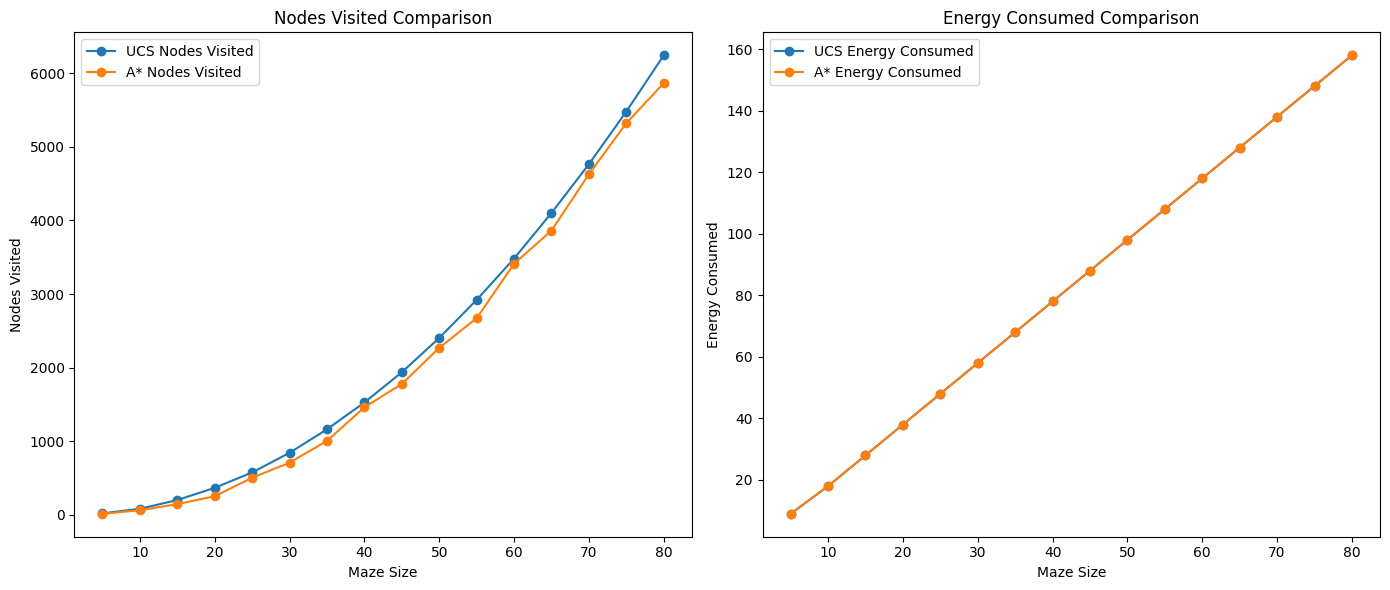

In [15]:
df = pd.DataFrame(results)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ax[0].plot(df['size'], df['iddfs_visited'], marker='o', label='IDDFS Nodes Visited')
ax[0].plot(df['size'], df['ucs_visited'], marker='o', label='UCS Nodes Visited')
ax[0].plot(df['size'], df['astar_visited'], marker='o', label='A* Nodes Visited')
ax[0].set_title('Nodes Visited Comparison')
ax[0].set_xlabel('Maze Size')
ax[0].set_ylabel('Nodes Visited')
ax[0].legend()

# ax[1].plot(df['size'], df['iddfs_energy'], marker='o', label='IDDFS Energy Consumed')
ax[1].plot(df['size'], df['ucs_energy'], marker='o', label='UCS Energy Consumed')
ax[1].plot(df['size'], df['astar_energy'], marker='o', label='A* Energy Consumed')
ax[1].set_title('Energy Consumed Comparison')
ax[1].set_xlabel('Maze Size')
ax[1].set_ylabel('Energy Consumed')
ax[1].legend()

plt.tight_layout()
plt.show()
